In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

class SkeletonDataset(Dataset):
    """
    Custom Dataset cho dữ liệu skeleton.
    Đọc dữ liệu từ file .npy và label từ file .pkl,
    sau đó định hình lại cho phù hợp với mô hình RNN/GRU.
    """
    def __init__(self, data_path, label_path):
        # Tải label
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)

        # Tải dữ liệu và chuyển sang tensor
        # Dữ liệu gốc có shape (N, C, T, V, M)
        raw_data = np.load(data_path)
        self.data = torch.from_numpy(raw_data).float()

        # Thông tin shape
        self.N, self.C, self.T, self.V, self.M = self.data.shape
        print(f"Loaded data from {data_path} with shape: ({self.N}, {self.C}, {self.T}, {self.V}, {self.M})")


    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Lấy dữ liệu và label tại index
        sample_data = self.data[index] # Shape: (C, T, V, M)
        label = self.labels[index]

        # Thay đổi shape để phù hợp với GRU
        # Chuyển (C, T, V, M) -> (T, C, V, M)
        sample_data = sample_data.permute(1, 0, 2, 3)

        # Làm phẳng các chiều C, V, M thành một vector đặc trưng duy nhất cho mỗi bước thời gian T
        # Shape sau khi làm phẳng: (T, C * V * M)
        # Ví dụ: (20, 3 * 61 * 1) = (20, 183)
        flattened_data = sample_data.reshape(self.T, -1)

        return flattened_data, torch.tensor(label, dtype=torch.long)

In [12]:
import random
def set_seed(seed_value):
    random.seed(seed_value) # Python's random module
    np.random.seed(seed_value) # NumPy
    torch.manual_seed(seed_value) # PyTorch on CPU
    torch.cuda.manual_seed_all(seed_value) # PyTorch on all GPUs (if available)
    
    # Cấu hình cho thuật toán cuDNN (thường được sử dụng bởi PyTorch trên GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Global seed set to {seed_value}")

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedGRUModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdvancedGRUModel, self).__init__()

        # --- Lớp GRU ---
        # Keras: GRU(128, return_sequences=True, activation='relu')
        # PyTorch: nn.GRU không hỗ trợ trực tiếp activation='relu'. 
        # Chúng ta sẽ sử dụng nn.GRU tiêu chuẩn và thảo luận về điểm này bên dưới.
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0)

        self.gru2 = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(0)

        self.gru3 = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
        self.dropout3 = nn.Dropout(0)
        
        self.gru4 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.dropout4 = nn.Dropout(0)

        # Lớp GRU cuối cùng, tương đương return_sequences=False
        self.gru5 = nn.GRU(input_size=512, hidden_size=512, batch_first=True)

        # --- Khối Classifier (MLP) ---
        # Sử dụng nn.Sequential để nhóm các lớp Dense lại cho gọn gàng
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),       # Tương đương BatchNormalization() sau GRU
            nn.Linear(512, 512),
            nn.ReLU(),                 # Tương đương activation='relu'
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes) # Lớp output, không có softmax (xem giải thích)
        )

    def forward(self, x):
        # Luồng dữ liệu qua các lớp GRU
        # self.gru(x) trả về (output, h_n)
        # output có shape (batch, seq_len, hidden_size)
        # h_n là hidden state cuối cùng
        
        # return_sequences=True
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        
        out, _ = self.gru2(out)
        out = self.dropout2(out)

        out, _ = self.gru3(out)
        out = self.dropout3(out)

        out, _ = self.gru4(out)
        out = self.dropout4(out)

        # Lớp GRU cuối, tương đương return_sequences=False
        out, _ = self.gru5(out)
        
        # Lấy output của bước thời gian cuối cùng
        out = out[:, -1, :] # Shape: (batch, hidden_size)

        # Cho qua khối classifier
        out = self.classifier(out)
        
        return out

In [14]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Hàm huấn luyện model trong một epoch."""
    model.train()  # Chuyển model sang chế độ training
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Hàm đánh giá model trên tập validation hoặc test."""
    model.eval()  # Chuyển model sang chế độ evaluation
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Không cần tính gradient khi đánh giá
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Thống kê
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward + loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + clip grads
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step optimizer + scheduler
        optimizer.step()
        scheduler.step()

        # Stats
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [16]:
from torch.optim.lr_scheduler import OneCycleLR

In [17]:
if __name__ == '__main__':
    # --- 1. Cấu hình & Hyperparameters ---
    DATA_DIR     = '/workspace/data/npy_splits_new'
    NUM_CLASSES  = 2139
    NUM_EPOCHS   = 100
    BATCH_SIZE   = 256
    LEARNING_RATE= 0.001

    set_seed(42)

    # --- 2. Chuẩn bị Dữ liệu ---
    train_dataset = SkeletonDataset(f'{DATA_DIR}/train_data.npy', f'{DATA_DIR}/train_label.pkl')
    val_dataset   = SkeletonDataset(f'{DATA_DIR}/val_data.npy',   f'{DATA_DIR}/val_label.pkl')
    test_dataset  = SkeletonDataset(f'{DATA_DIR}/test_data.npy',  f'{DATA_DIR}/test_label.pkl')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # --- 3. Model, Loss, Optimizer, Scheduler ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = AdvancedGRUModel(input_size=3*61*1, num_classes=NUM_CLASSES).to(device)
    print("--- Model Architecture ---")
    print(model)
    print("--------------------------")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * 5,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1e4
    )

    # --- 4. Training Loop ---
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion,
            optimizer, scheduler, device
        )
        print(f"Train  | Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val    | Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # --- 5. Final Test ---
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nTest   | Loss: {test_loss:.4f}  Acc: {test_acc:.4f}")

Global seed set to 42


Loaded data from /workspace/data/npy_splits_new/train_data.npy with shape: (169408, 3, 24, 61, 1)
Loaded data from /workspace/data/npy_splits_new/val_data.npy with shape: (42353, 3, 24, 61, 1)
Loaded data from /workspace/data/npy_splits_new/test_data.npy with shape: (2139, 3, 24, 61, 1)
Using device: cuda
--- Model Architecture ---
AdvancedGRUModel(
  (gru1): GRU(183, 128, batch_first=True)
  (dropout1): Dropout(p=0, inplace=False)
  (gru2): GRU(128, 128, batch_first=True)
  (dropout2): Dropout(p=0, inplace=False)
  (gru3): GRU(128, 256, batch_first=True)
  (dropout3): Dropout(p=0, inplace=False)
  (gru4): GRU(256, 512, batch_first=True)
  (dropout4): Dropout(p=0, inplace=False)
  (gru5): GRU(512, 512, batch_first=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReL

Training: 100%|██████████| 662/662 [00:07<00:00, 86.24it/s]


Train  | Loss: 6.4149  Acc: 0.0065


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.11it/s]


Val    | Loss: 5.7029  Acc: 0.0100

--- Epoch 2/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.43it/s]


Train  | Loss: 5.0983  Acc: 0.0151


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.20it/s]


Val    | Loss: 4.9391  Acc: 0.0149

--- Epoch 3/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.47it/s]


Train  | Loss: 4.7891  Acc: 0.0234


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.90it/s]


Val    | Loss: 4.8628  Acc: 0.0209

--- Epoch 4/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.12it/s]


Train  | Loss: 4.0516  Acc: 0.0564


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.18it/s]


Val    | Loss: 4.0608  Acc: 0.0446

--- Epoch 5/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 82.23it/s]


Train  | Loss: 3.6810  Acc: 0.0797


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.62it/s]


Val    | Loss: 3.8518  Acc: 0.0572

--- Epoch 6/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 86.91it/s]


Train  | Loss: 3.4913  Acc: 0.1048


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.62it/s]


Val    | Loss: 4.4646  Acc: 0.0433

--- Epoch 7/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.07it/s]


Train  | Loss: 2.8058  Acc: 0.2190


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.23it/s]


Val    | Loss: 2.2000  Acc: 0.3284

--- Epoch 8/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 86.79it/s]


Train  | Loss: 1.7999  Acc: 0.4415


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.57it/s]


Val    | Loss: 1.0979  Acc: 0.6482

--- Epoch 9/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.74it/s]


Train  | Loss: 1.1758  Acc: 0.6266


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.24it/s]


Val    | Loss: 1.7111  Acc: 0.4961

--- Epoch 10/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.56it/s]


Train  | Loss: 0.7114  Acc: 0.7752


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.03it/s]


Val    | Loss: 0.7347  Acc: 0.7821

--- Epoch 11/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.93it/s]


Train  | Loss: 0.4851  Acc: 0.8501


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.69it/s]


Val    | Loss: 1.4152  Acc: 0.6118

--- Epoch 12/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.54it/s]


Train  | Loss: 0.3996  Acc: 0.8770


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.02it/s]


Val    | Loss: 0.5764  Acc: 0.8337

--- Epoch 13/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.16it/s]


Train  | Loss: 0.3534  Acc: 0.8921


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 156.28it/s]


Val    | Loss: 0.2742  Acc: 0.9205

--- Epoch 14/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.98it/s]


Train  | Loss: 0.3309  Acc: 0.9011


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 155.64it/s]


Val    | Loss: 0.5743  Acc: 0.8358

--- Epoch 15/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.29it/s]


Train  | Loss: 0.3028  Acc: 0.9102


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.56it/s]


Val    | Loss: 1.2228  Acc: 0.7222

--- Epoch 16/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.73it/s]


Train  | Loss: 0.2844  Acc: 0.9168


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.86it/s]


Val    | Loss: 0.5255  Acc: 0.8652

--- Epoch 17/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.27it/s]


Train  | Loss: 0.2742  Acc: 0.9216


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.03it/s]


Val    | Loss: 0.6167  Acc: 0.8429

--- Epoch 18/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.91it/s]


Train  | Loss: 0.2576  Acc: 0.9264


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.33it/s]


Val    | Loss: 1.9940  Acc: 0.6145

--- Epoch 19/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.37it/s]


Train  | Loss: 0.2409  Acc: 0.9317


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.95it/s]


Val    | Loss: 1.1085  Acc: 0.7706

--- Epoch 20/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.05it/s]


Train  | Loss: 0.2368  Acc: 0.9350


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 148.01it/s]


Val    | Loss: 5.3138  Acc: 0.3550

--- Epoch 21/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.34it/s]


Train  | Loss: 0.2246  Acc: 0.9380


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 149.64it/s]


Val    | Loss: 1.8533  Acc: 0.6613

--- Epoch 22/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.35it/s]


Train  | Loss: 0.2151  Acc: 0.9414


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.75it/s]


Val    | Loss: 2.9335  Acc: 0.5471

--- Epoch 23/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.44it/s]


Train  | Loss: 0.2068  Acc: 0.9433


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.13it/s]


Val    | Loss: 2.7383  Acc: 0.6060

--- Epoch 24/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.52it/s]


Train  | Loss: 0.2023  Acc: 0.9451


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.06it/s]


Val    | Loss: 0.7487  Acc: 0.8342

--- Epoch 25/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 82.00it/s]


Train  | Loss: 0.1971  Acc: 0.9473


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.52it/s]


Val    | Loss: 4.6544  Acc: 0.4837

--- Epoch 26/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.89it/s]


Train  | Loss: 0.1976  Acc: 0.9476


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.22it/s]


Val    | Loss: 1.2022  Acc: 0.7558

--- Epoch 27/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.45it/s]


Train  | Loss: 0.1937  Acc: 0.9489


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.96it/s]


Val    | Loss: 0.3101  Acc: 0.9312

--- Epoch 28/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 86.65it/s]


Train  | Loss: 0.1943  Acc: 0.9501


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.85it/s]


Val    | Loss: 2.5394  Acc: 0.6280

--- Epoch 29/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.87it/s]


Train  | Loss: 0.1932  Acc: 0.9507


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.30it/s]


Val    | Loss: 0.4308  Acc: 0.9098

--- Epoch 30/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.42it/s]


Train  | Loss: 0.1937  Acc: 0.9514


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 155.97it/s]


Val    | Loss: 1.2884  Acc: 0.7833

--- Epoch 31/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.19it/s]


Train  | Loss: 0.1969  Acc: 0.9523


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.75it/s]


Val    | Loss: 0.2710  Acc: 0.9407

--- Epoch 32/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.18it/s]


Train  | Loss: 0.1915  Acc: 0.9542


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.63it/s]


Val    | Loss: 0.4426  Acc: 0.9081

--- Epoch 33/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.45it/s]


Train  | Loss: 0.1910  Acc: 0.9539


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.71it/s]


Val    | Loss: 0.4086  Acc: 0.9151

--- Epoch 34/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 77.94it/s]


Train  | Loss: 0.1941  Acc: 0.9548


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.08it/s]


Val    | Loss: 1.1025  Acc: 0.8133

--- Epoch 35/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.49it/s]


Train  | Loss: 0.1949  Acc: 0.9561


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.79it/s]


Val    | Loss: 0.2191  Acc: 0.9527

--- Epoch 36/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.66it/s]


Train  | Loss: 0.1922  Acc: 0.9566


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.26it/s]


Val    | Loss: 0.5134  Acc: 0.8974

--- Epoch 37/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.68it/s]


Train  | Loss: 0.2052  Acc: 0.9549


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.53it/s]


Val    | Loss: 0.2038  Acc: 0.9573

--- Epoch 38/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 82.45it/s]


Train  | Loss: 0.1961  Acc: 0.9571


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.80it/s]


Val    | Loss: 5.5865  Acc: 0.5402

--- Epoch 39/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.51it/s]


Train  | Loss: 0.2016  Acc: 0.9581


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.30it/s]


Val    | Loss: 0.7008  Acc: 0.8786

--- Epoch 40/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 86.06it/s]


Train  | Loss: 0.2026  Acc: 0.9579


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.09it/s]


Val    | Loss: 1.8351  Acc: 0.7517

--- Epoch 41/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.34it/s]


Train  | Loss: 0.1910  Acc: 0.9604


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.59it/s]


Val    | Loss: 1.1592  Acc: 0.8298

--- Epoch 42/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.06it/s]


Train  | Loss: 0.1898  Acc: 0.9600


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 155.57it/s]


Val    | Loss: 1.7339  Acc: 0.8022

--- Epoch 43/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 82.71it/s]


Train  | Loss: 0.2011  Acc: 0.9596


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.18it/s]


Val    | Loss: 0.3758  Acc: 0.9381

--- Epoch 44/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.49it/s]


Train  | Loss: 0.1859  Acc: 0.9622


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.18it/s]


Val    | Loss: 0.5016  Acc: 0.9094

--- Epoch 45/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.35it/s]


Train  | Loss: 0.1844  Acc: 0.9637


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.71it/s]


Val    | Loss: 0.2361  Acc: 0.9549

--- Epoch 46/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.63it/s]


Train  | Loss: 0.1851  Acc: 0.9641


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.59it/s]


Val    | Loss: 1.2774  Acc: 0.8591

--- Epoch 47/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 87.31it/s]


Train  | Loss: 0.1859  Acc: 0.9655


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.75it/s]


Val    | Loss: 0.4334  Acc: 0.9340

--- Epoch 48/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 74.24it/s]


Train  | Loss: 0.1752  Acc: 0.9664


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.89it/s]


Val    | Loss: 0.4200  Acc: 0.9365

--- Epoch 49/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.67it/s]


Train  | Loss: 0.1752  Acc: 0.9676


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.49it/s]


Val    | Loss: 0.2588  Acc: 0.9630

--- Epoch 50/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.27it/s]


Train  | Loss: 0.1745  Acc: 0.9693


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.27it/s]


Val    | Loss: 0.3717  Acc: 0.9388

--- Epoch 51/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.13it/s]


Train  | Loss: 0.1640  Acc: 0.9699


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.93it/s]


Val    | Loss: 0.5088  Acc: 0.9188

--- Epoch 52/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.44it/s]


Train  | Loss: 0.1551  Acc: 0.9715


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 155.37it/s]


Val    | Loss: 0.7010  Acc: 0.8956

--- Epoch 53/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 77.59it/s]


Train  | Loss: 0.1488  Acc: 0.9732


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.29it/s]


Val    | Loss: 0.3646  Acc: 0.9494

--- Epoch 54/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.52it/s]


Train  | Loss: 0.1452  Acc: 0.9739


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.36it/s]


Val    | Loss: 0.3288  Acc: 0.9578

--- Epoch 55/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.76it/s]


Train  | Loss: 0.1431  Acc: 0.9745


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.89it/s]


Val    | Loss: 0.3571  Acc: 0.9544

--- Epoch 56/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.52it/s]


Train  | Loss: 0.1416  Acc: 0.9756


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.67it/s]


Val    | Loss: 0.2862  Acc: 0.9601

--- Epoch 57/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.45it/s]


Train  | Loss: 0.1267  Acc: 0.9774


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.45it/s]


Val    | Loss: 2.9551  Acc: 0.7933

--- Epoch 58/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.16it/s]


Train  | Loss: 0.1339  Acc: 0.9768


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.55it/s]


Val    | Loss: 1.3177  Acc: 0.8778

--- Epoch 59/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.06it/s]


Train  | Loss: 0.1138  Acc: 0.9796


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.15it/s]


Val    | Loss: 0.5528  Acc: 0.9302

--- Epoch 60/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 76.30it/s]


Train  | Loss: 0.1060  Acc: 0.9803


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.87it/s]


Val    | Loss: 0.0902  Acc: 0.9869

--- Epoch 61/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.30it/s]


Train  | Loss: 0.1088  Acc: 0.9809


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.08it/s]


Val    | Loss: 3.9753  Acc: 0.7909

--- Epoch 62/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.68it/s]


Train  | Loss: 0.1019  Acc: 0.9823


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.78it/s]


Val    | Loss: 0.0964  Acc: 0.9864

--- Epoch 63/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.52it/s]


Train  | Loss: 0.0895  Acc: 0.9840


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.65it/s]


Val    | Loss: 1.0897  Acc: 0.8957

--- Epoch 64/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.65it/s]


Train  | Loss: 0.0881  Acc: 0.9841


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.50it/s]


Val    | Loss: 0.0866  Acc: 0.9870

--- Epoch 65/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.92it/s]


Train  | Loss: 0.0781  Acc: 0.9850


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.17it/s]


Val    | Loss: 0.1545  Acc: 0.9780

--- Epoch 66/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 77.94it/s]


Train  | Loss: 0.0747  Acc: 0.9861


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.90it/s]


Val    | Loss: 0.1410  Acc: 0.9813

--- Epoch 67/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 82.19it/s]


Train  | Loss: 0.0686  Acc: 0.9866


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 156.70it/s]


Val    | Loss: 0.0689  Acc: 0.9892

--- Epoch 68/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.04it/s]


Train  | Loss: 0.0613  Acc: 0.9876


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.29it/s]


Val    | Loss: 0.4851  Acc: 0.9544

--- Epoch 69/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.75it/s]


Train  | Loss: 0.0574  Acc: 0.9884


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.19it/s]


Val    | Loss: 0.0924  Acc: 0.9882

--- Epoch 70/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 86.43it/s]


Train  | Loss: 0.0487  Acc: 0.9894


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.07it/s]


Val    | Loss: 0.1291  Acc: 0.9862

--- Epoch 71/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.12it/s]


Train  | Loss: 0.0461  Acc: 0.9895


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.18it/s]


Val    | Loss: 0.0627  Acc: 0.9900

--- Epoch 72/100 ---


Training: 100%|██████████| 662/662 [00:09<00:00, 73.18it/s]


Train  | Loss: 0.0444  Acc: 0.9902


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.36it/s]


Val    | Loss: 0.0816  Acc: 0.9905

--- Epoch 73/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 73.58it/s]


Train  | Loss: 0.0367  Acc: 0.9910


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.07it/s]


Val    | Loss: 0.0779  Acc: 0.9914

--- Epoch 74/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.93it/s]


Train  | Loss: 0.0344  Acc: 0.9919


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.37it/s]


Val    | Loss: 0.0825  Acc: 0.9906

--- Epoch 75/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.17it/s]


Train  | Loss: 0.0327  Acc: 0.9918


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.69it/s]


Val    | Loss: 0.1055  Acc: 0.9901

--- Epoch 76/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 76.39it/s]


Train  | Loss: 0.0299  Acc: 0.9927


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.86it/s]


Val    | Loss: 0.0642  Acc: 0.9919

--- Epoch 77/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.85it/s]


Train  | Loss: 0.0228  Acc: 0.9933


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.60it/s]


Val    | Loss: 0.0636  Acc: 0.9937

--- Epoch 78/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 82.98it/s]


Train  | Loss: 0.0215  Acc: 0.9936


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.46it/s]


Val    | Loss: 0.0954  Acc: 0.9925

--- Epoch 79/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.50it/s]


Train  | Loss: 0.0217  Acc: 0.9933


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.86it/s]


Val    | Loss: 0.0852  Acc: 0.9924

--- Epoch 80/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.08it/s]


Train  | Loss: 0.0171  Acc: 0.9946


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.11it/s]


Val    | Loss: 0.0621  Acc: 0.9942

--- Epoch 81/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.01it/s]


Train  | Loss: 0.0175  Acc: 0.9947


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.34it/s]


Val    | Loss: 0.0573  Acc: 0.9938

--- Epoch 82/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.30it/s]


Train  | Loss: 0.0162  Acc: 0.9948


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.34it/s]


Val    | Loss: 0.0570  Acc: 0.9942

--- Epoch 83/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.83it/s]


Train  | Loss: 0.0147  Acc: 0.9951


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.61it/s]


Val    | Loss: 0.0528  Acc: 0.9938

--- Epoch 84/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 84.70it/s]


Train  | Loss: 0.0139  Acc: 0.9953


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 149.01it/s]


Val    | Loss: 0.0606  Acc: 0.9946

--- Epoch 85/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.47it/s]


Train  | Loss: 0.0125  Acc: 0.9958


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.67it/s]


Val    | Loss: 0.0799  Acc: 0.9942

--- Epoch 86/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.09it/s]


Train  | Loss: 0.0115  Acc: 0.9958


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 154.19it/s]


Val    | Loss: 0.0561  Acc: 0.9947

--- Epoch 87/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.49it/s]


Train  | Loss: 0.0110  Acc: 0.9958


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.62it/s]


Val    | Loss: 0.0557  Acc: 0.9951

--- Epoch 88/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 79.90it/s]


Train  | Loss: 0.0097  Acc: 0.9962


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.08it/s]


Val    | Loss: 0.0538  Acc: 0.9953

--- Epoch 89/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.78it/s]


Train  | Loss: 0.0099  Acc: 0.9964


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 150.75it/s]


Val    | Loss: 0.0586  Acc: 0.9950

--- Epoch 90/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 80.78it/s]


Train  | Loss: 0.0094  Acc: 0.9965


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.63it/s]


Val    | Loss: 0.0612  Acc: 0.9955

--- Epoch 91/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.86it/s]


Train  | Loss: 0.0089  Acc: 0.9967


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.57it/s]


Val    | Loss: 0.0570  Acc: 0.9955

--- Epoch 92/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.28it/s]


Train  | Loss: 0.0082  Acc: 0.9971


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.04it/s]


Val    | Loss: 0.0597  Acc: 0.9958

--- Epoch 93/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 83.55it/s]


Train  | Loss: 0.0078  Acc: 0.9973


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 155.94it/s]


Val    | Loss: 0.0604  Acc: 0.9958

--- Epoch 94/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.22it/s]


Train  | Loss: 0.0076  Acc: 0.9973


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.48it/s]


Val    | Loss: 0.0598  Acc: 0.9962

--- Epoch 95/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 76.53it/s]


Train  | Loss: 0.0073  Acc: 0.9975


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 149.00it/s]


Val    | Loss: 0.0579  Acc: 0.9962

--- Epoch 96/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 81.52it/s]


Train  | Loss: 0.0070  Acc: 0.9975


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 153.09it/s]


Val    | Loss: 0.0569  Acc: 0.9962

--- Epoch 97/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.94it/s]


Train  | Loss: 0.0070  Acc: 0.9975


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 151.66it/s]


Val    | Loss: 0.0572  Acc: 0.9963

--- Epoch 98/100 ---


Training: 100%|██████████| 662/662 [00:07<00:00, 85.03it/s]


Train  | Loss: 0.0069  Acc: 0.9977


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.98it/s]


Val    | Loss: 0.0590  Acc: 0.9963

--- Epoch 99/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.91it/s]


Train  | Loss: 0.0068  Acc: 0.9976


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 146.28it/s]


Val    | Loss: 0.0575  Acc: 0.9962

--- Epoch 100/100 ---


Training: 100%|██████████| 662/662 [00:08<00:00, 78.68it/s]


Train  | Loss: 0.0067  Acc: 0.9978


Evaluating: 100%|██████████| 166/166 [00:01<00:00, 152.84it/s]


Val    | Loss: 0.0588  Acc: 0.9964


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 39.24it/s]


Test   | Loss: 92.6517  Acc: 0.2950


In [21]:
torch.save(model.state_dict(), '/workspace/data/log/hdf5/ced_gru_model.pth')
print("Model saved to advanced_gru_model.pth")

Model saved to advanced_gru_model.pth


In [18]:
import matplotlib.pyplot as plt

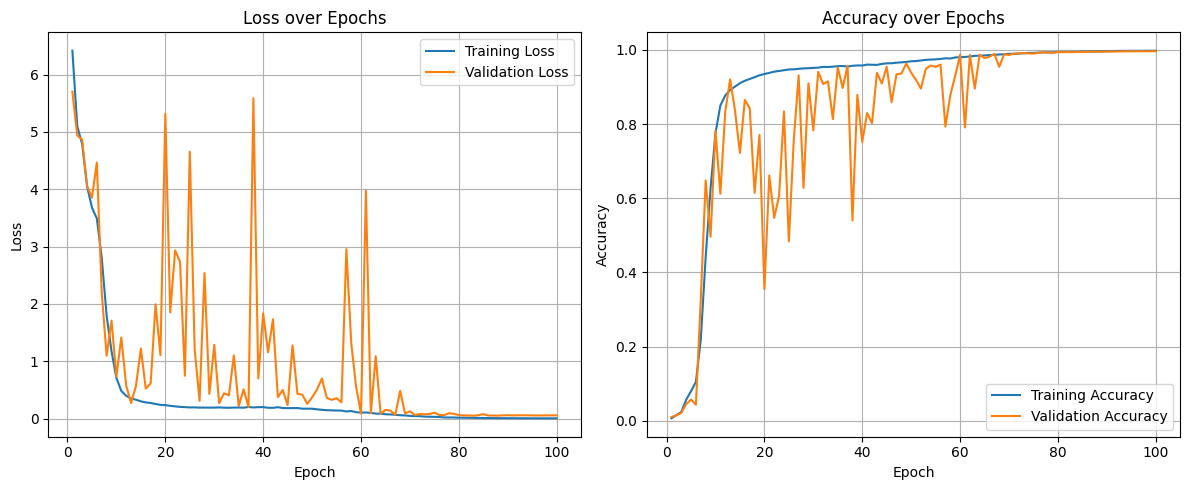

Plots generated successfully!


In [22]:
epochs_range = range(1, NUM_EPOCHS + 1) 
plt.figure(figsize=(12, 5)) # Tạo một hình vẽ mới với kích thước 12x5 inches
plt.subplot(1, 2, 1) # Tạo biểu đồ con thứ nhất (1 hàng, 2 cột)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # Tạo biểu đồ con thứ hai (1 hàng, 2 cột)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ con để tránh chồng chéo
plt.show() # Hiển thị các biểu đồ
print("Plots generated successfully!")

In [20]:
# if __name__ == '__main__':
#     # --- 1. Cấu hình & Hyperparameters ---
#     DATA_DIR = '/workspace/data/npy_100'  # THAY ĐỔI ĐƯỜNG DẪN NÀY
#     NUM_CLASSES = 2139                         # THAY ĐỔI số lượng lớp (class) nếu cần
#     set_seed(42)  # Đặt seed toàn cục để đảm bảo tính tái lập
#     # Model Hyperparameters
#     # Với AdvancedGRUModel, các giá trị hidden_size và num_layers đã được định nghĩa
#     # cứng bên trong kiến trúc model, nên chúng ta không cần truyền vào nữa.
#     INPUT_SIZE = 3 * 61 * 1  # C * V * M
    
#     # Training Hyperparameters
#     NUM_EPOCHS = 200
#     BATCH_SIZE = 256
#     LEARNING_RATE = 0.001

#     # --- 2. Chuẩn bị Dữ liệu ---
#     # Tạo Datasets (phần này giữ nguyên)
#     train_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/train_data.npy',
#         label_path=f'{DATA_DIR}/train_label.pkl'
#     )
#     val_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/val_data.npy',
#         label_path=f'{DATA_DIR}/val_label.pkl'
#     )
#     test_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/test_data.npy',
#         label_path=f'{DATA_DIR}/test_label.pkl'
#     )

#     # Tạo DataLoaders (phần này giữ nguyên)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#     # --- 3. Khởi tạo Model, Loss, Optimizer ---
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")

#     # **THAY ĐỔI CHÍNH Ở ĐÂY**
#     # Khởi tạo model AdvancedGRUModel với các tham số cần thiết
#     model = AdvancedGRUModel(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
#     print("--- Model Architecture ---")
#     print(model)
#     print("--------------------------")

#     # Hàm mất mát và trình tối ưu hóa (giữ nguyên)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
    
#     # --- 4. Vòng lặp Huấn luyện --- (giữ nguyên)
#     for epoch in range(NUM_EPOCHS):
#         print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#         print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)
#         print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)

#     print("\n--- Training Finished ---")

#     # --- 5. Đánh giá cuối cùng trên tập Test --- (giữ nguyên)
#     test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#     print(f"\nFinal Test Results | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

#     # (Tùy chọn) Lưu model
#     # torch.save(model.state_dict(), 'advanced_gru_model.pth')
#     # print("Model saved to advanced_gru_model.pth")